In [1]:
import matplotlib.pyplot as plt
import matplotlib.axes as axes
%matplotlib inline
import numpy as np
import networkx as nx

from qiskit import BasicAer
from qiskit.tools.visualization import plot_histogram
from qiskit.circuit.library import TwoLocal
from qiskit.optimization.applications.ising import max_cut
from qiskit.aqua.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.aqua.components.optimizers import SPSA
from qiskit.aqua import QuantumInstance
from qiskit.optimization.applications.ising.common import sample_most_likely

# setup aqua logging
import logging
from qiskit.aqua import set_qiskit_aqua_logging

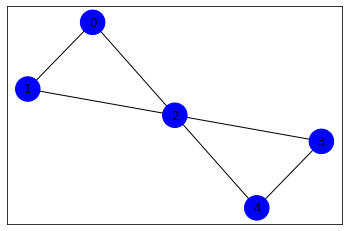

In [8]:
n     = 5
V     = np.arange(0,n,1)
E     =[(0,1,1.0),(0,2,1.0),(1,2,1.0),(3,2,1.0),(3,4,1.0),(4,2,1.0)] 

G     = nx.Graph()
G.add_nodes_from(V)
G.add_weighted_edges_from(E)

# Generate plot of the Graph
colors       = ['b' for node in G.nodes()]
default_axes = plt.axes(frameon=True)
pos          = nx.spring_layout(G)

nx.draw_networkx(G, node_color=colors, node_size=600, alpha=1, ax=default_axes, pos=pos)

In [9]:
w = np.zeros([n,n])
for i in range(n):
    for j in range(n):
        temp = G.get_edge_data(i,j,default=0)
        if temp != 0:
            w[i,j] = temp['weight'] 
print(w)

[[0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 0.]
 [1. 1. 0. 1. 1.]
 [0. 0. 1. 0. 1.]
 [0. 0. 1. 1. 0.]]


In [10]:
qubitOp, offset = max_cut.get_operator(w)

In [15]:
%%time
ee = NumPyMinimumEigensolver(qubitOp)
result = ee.run()

CPU times: user 9.67 ms, sys: 117 µs, total: 9.79 ms
Wall time: 8.6 ms


energy: -1.0
max-cut objective: -4.0
solution: [1 0 0 0 1]
solution objective: 4.0


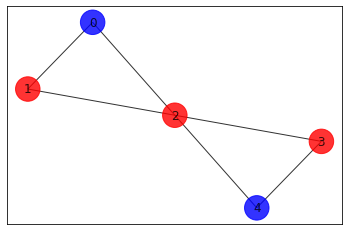

In [16]:
x = sample_most_likely(result.eigenstate)
print('energy:', result.eigenvalue.real)
print('max-cut objective:', result.eigenvalue.real + offset)
print('solution:', max_cut.get_graph_solution(x))
print('solution objective:', max_cut.max_cut_value(x, w))

colors = ['r' if max_cut.get_graph_solution(x)[i] == 0 else 'b' for i in range(n)]
nx.draw_networkx(G, node_color=colors, node_size=600, alpha = .8, pos=pos)

In [20]:
%%time

seed = 10598

spsa = SPSA(max_trials=300)
ry = TwoLocal(qubitOp.num_qubits, 'ry', 'cz', reps=5, entanglement='linear')
vqe = VQE(qubitOp, ry, spsa)

backend = BasicAer.get_backend('statevector_simulator')
quantum_instance = QuantumInstance(backend, seed_simulator=seed, seed_transpiler=seed)

result = vqe.run(quantum_instance)

CPU times: user 5.14 s, sys: 70.2 ms, total: 5.21 s
Wall time: 9.23 s


energy: -0.9997380404036
time: 9.104193925857544
max-cut objective: -3.9997380404036003
solution: [0. 1. 0. 0. 1.]
solution objective: 4.0


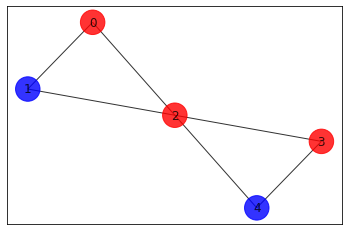

In [21]:
x = sample_most_likely(result.eigenstate)
print('Energy:', result.eigenvalue.real)
print('Time:', result.optimizer_time)
print('Max-cut objective:', result.eigenvalue.real + offset)
print('Solution:', max_cut.get_graph_solution(x))
print('Solution objective:', max_cut.max_cut_value(x, w))

colors = ['r' if max_cut.get_graph_solution(x)[i] == 0 else 'b' for i in range(n)]
nx.draw_networkx(G, node_color=colors, node_size=600, alpha = .8, pos=pos)

energy: -1.0
time: 17.904709339141846
max-cut objective: -4.0
solution: [0 1 0 0 1]
solution objective: 4.0


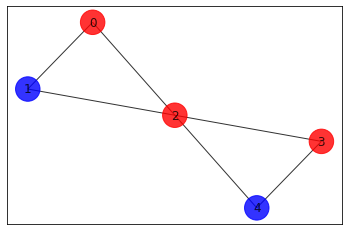

In [22]:
# run quantum algorithm with shots
seed = 10598

spsa = SPSA(max_trials=300)
ry = TwoLocal(qubitOp.num_qubits, 'ry', 'cz', reps=5, entanglement='linear')
vqe = VQE(qubitOp, ry, spsa)

backend = BasicAer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed)

result = vqe.run(quantum_instance)

x = sample_most_likely(result.eigenstate)
print('energy:', result.eigenvalue.real)
print('time:', result.optimizer_time)
print('max-cut objective:', result.eigenvalue.real + offset)
print('solution:', max_cut.get_graph_solution(x))
print('solution objective:', max_cut.max_cut_value(x, w))
plot_histogram(result.eigenstate)

colors = ['r' if max_cut.get_graph_solution(x)[i] == 0 else 'b' for i in range(n)]
nx.draw_networkx(G, node_color=colors, node_size=600, alpha = .8, pos=pos)